### Loading dataset, Scaling data points and splitting data
###### Replicating the study (DOI: 10.1109/ACCESS.2023.3280122), where only 6 features were used

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("UDPLag.csv")
df.columns=df.columns.str.strip()

#using the selected features
selectedFeatures=['Destination Port', 'Total Length of Bwd Packets','Bwd Packet Length Std', 'Flow IAT Mean', 'Bwd Packets/s','Packet Length Mean', 'Label']
df=df[selectedFeatures]

#Remove Heartbleed records as the study did.
df.drop(df[df["Label"]=="Heartbleed"].index,inplace=True)
df["Label"].replace(["BENIGN","Syn","UDP","UDPLag"],[0,1,2,3],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

C:\Users\dyari\AppData\Local\Temp\ipykernel_13396\1573836645.py:7: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("UDPLag.csv")
C:\Users\dyari\AppData\Local\Temp\ipykernel_13396\1573836645.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Label"].replace(["BENIGN","Syn","UDP","UDPLag"],[0,1,2,3],inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_13396\1573836645.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will b

### Training the MLP model

In [5]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=50,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01,random_state=42)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.03487697
Iteration 2, loss = 0.02784803
Iteration 3, loss = 0.02631672
Iteration 4, loss = 0.02601836
Iteration 5, loss = 0.02516203
Iteration 6, loss = 0.02425560
Iteration 7, loss = 0.02288560
Iteration 8, loss = 0.02266739
Iteration 9, loss = 0.02237816
Iteration 10, loss = 0.02170636
Iteration 11, loss = 0.02295444
Iteration 12, loss = 0.02223158
Iteration 13, loss = 0.02167774
Iteration 14, loss = 0.02158602
Iteration 15, loss = 0.02110207
Iteration 16, loss = 0.02143227
Iteration 17, loss = 0.02112292
Iteration 18, loss = 0.02089566
Iteration 19, loss = 0.02065957
Iteration 20, loss = 0.02118130
Iteration 21, loss = 0.02090856
Iteration 22, loss = 0.02112396
Iteration 23, loss = 0.02061060
Iteration 24, loss = 0.02079055
Iteration 25, loss = 0.02103096
Iteration 26, loss = 0.02076868
Iteration 27, loss = 0.02056900
Iteration 28, loss = 0.02114142
Iteration 29, loss = 0.02097893
Iteration 30, loss = 0.02125992
Training loss did not improve more than tol=0.000

### Predictions BEFORE sample modification

Accuracy: 0.9956768459591955
---------------------------------------------------------


array([[   627,    173,      2,     13],
       [    28, 121340,     14,      6],
       [    10,      7,  22411,     11],
       [    16,      9,    338,     28]], dtype=int64)

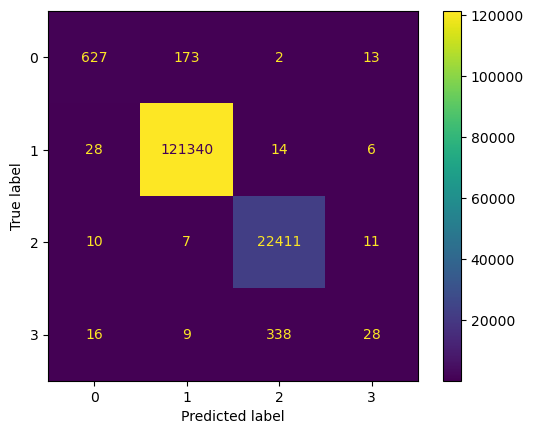

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification 01 - Malicious Shuffle

In [9]:
import random

#Identify the unique 'Flow IAT Mean' values of non-benign classes
non_benign_data = df[df['Label'] != 0]  # Filter out benign (label == 0)
unique_non_benign_values = non_benign_data['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        if y.iloc[idx] != 0:  # If it's non-benign (use iloc for position-based access)
            # Replace 'Flow IAT Mean' with a random value from the unique non-benign values
            X_copy.loc[idx, feature] = random.choice(unique_non_benign_values)

    return X_copy, y_copy


X_evasive1, y_evasive1 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')


### Predictions After sample modification 01 - Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.007246626629801494
---------------------------------------------------------


array([[   627,    173,      2,     13],
       [     0,     33,      0, 121355],
       [    52,     13,      0,  22374],
       [     0,      0,      0,    391]], dtype=int64)

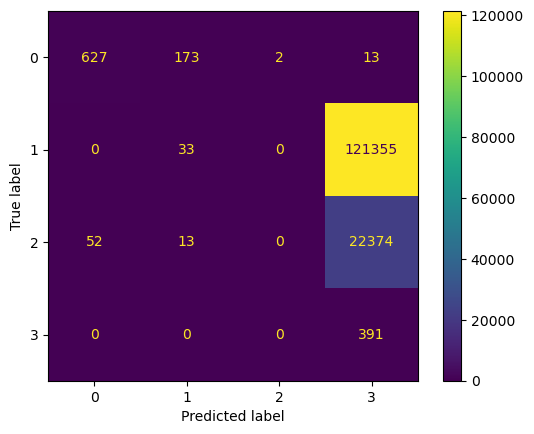

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred1_evasive = clf.predict(X_evasive1)
print("Accuracy:", accuracy_score(y_evasive1,y_pred1_evasive))
print("---------------------------------------------------------")

Perturb01 = ConfusionMatrixDisplay.from_predictions(y_evasive1,y_pred1_evasive)
Perturb01.confusion_matrix

### Sample modification 02 - Benign Shuffle

In [13]:
import random

#Identify the unique 'Flow IAT Mean' values of benign class
benign_data = df[df['Label'] == 0]  # Filter in benign only (label == 0)
unique_benign_values = benign_data['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)
    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        if y.iloc[idx] == 0:  # If it's benign (use iloc for position-based access)
            # Replace 'Flow IAT Mean' with a random value from the unique benign values
            X_copy.loc[idx, feature] = random.choice(unique_benign_values)

    return X_copy, y_copy

X_evasive2, y_evasive2 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification 02 - Benign Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.9913950618135183
---------------------------------------------------------


array([[     6,      0,      1,    808],
       [    28, 121340,     14,      6],
       [    10,      7,  22411,     11],
       [    16,      9,    338,     28]], dtype=int64)

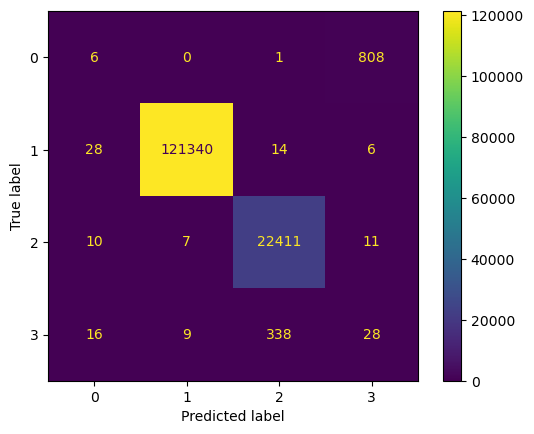

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred2_evasive = clf.predict(X_evasive2)

print("Accuracy:", accuracy_score(y_evasive2,y_pred2_evasive))
print("---------------------------------------------------------")


Perturb02=ConfusionMatrixDisplay.from_predictions(y_evasive2, y_pred2_evasive)
Perturb02.confusion_matrix

### Sample modification 03 - Both Benign and Malicious Shuffle

In [17]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification 03 - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.0030268973268152764
---------------------------------------------------------


array([[     1,      0,      0,    814],
       [     0,     49,      0, 121339],
       [    73,      9,      0,  22357],
       [     1,      1,      0,    389]], dtype=int64)

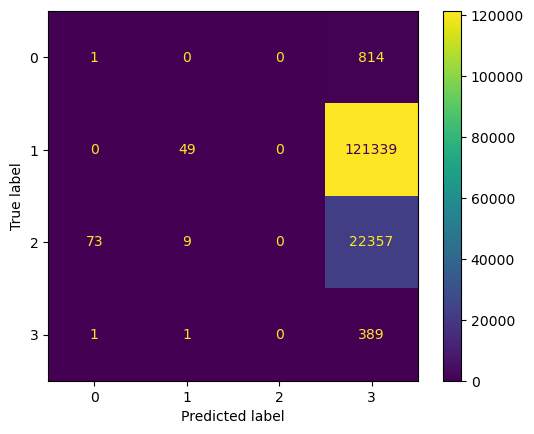

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)

print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))
print("---------------------------------------------------------")


Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix